In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize


In [2]:
# Load the dataset
df = pd.read_csv('London_Listings.csv')

# Original shape
print('Original Shape:', df.shape)

# First 5 rows
df.head()

Original Shape: (66679, 31)


,id,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,amenities,price,minimum_nights,maximum_nights,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,calculated_host_listings_count
0,2.763150e+07,1,NaN,35877912,Alex,15/06/2015,NaN,NaN,f,1.0,...,"[""Kitchen"", ""Refrigerator"", ""Microwave"", ""Free...",$200.00,1,1125,14/06/2024,0,NaN,NaN,NaN,1
1,1.100000e+18,1,Get comfortable and enjoy plenty of extra room...,564055882,Lili-Ann,26/02/2024,NaN,NaN,f,1.0,...,[],$675.00,1,365,15/06/2024,0,NaN,NaN,NaN,1
2,1.170000e+18,117,Keep it simple at this peaceful and centrally-...,528033284,Shujauddin,26/07/2023,86%,50%,f,2.0,...,"[""Washer"", ""Wifi"", ""Kitchen""]",$95.00,1,365,16/06/2024,0,NaN,NaN,NaN,2
3,8.730000e+17,- Bright Central London Apartment -,My apartment has everything you possibly need ...,99268099,Alex,11/10/2016,98%,93%,t,5.0,...,"[""Microwave"", ""Hot water kettle"", ""Body soap"",...",$166.00,7,365,16/06/2024,24,24/04/2023,02/05/2024,4.83,1
4,4.672403e+07,""" Bright & Cosy Loft apartment """,Lovely and cosy arctic space with a separate d...,359199241,Karol,29/07/2020,100%,95%,t,1.0,...,"[""Cleaning products"", ""Cooking basics"", ""First...",$105.00,2,60,14/06/2024,46,20/08/2021,02/06/2024,4.89,1


In [3]:
# Check types before categorising
print(df.dtypes)

id                                float64
name                               object
description                        object
host_id                             int64
host_name                          object
host_since                         object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_listings_count               float64
host_total_listings_count         float64
neighbourhood                      object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                    

In [4]:
# Organise the coluns in categorical and numerical types
categorical_var = df.select_dtypes(include=['object']).columns.tolist()
numerical_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Variables:", categorical_var)
print("Numerical Variables:", numerical_var)

Categorical Variables: ['name', 'description', 'host_name', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'calendar_last_scraped', 'first_review', 'last_review']
Numerical Variables: ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count']


In [5]:
# Fix the price column by removing $ sign and commas.
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Remove listings with zero or negative prices
df = df[df['price'] > 0]
print(df['price'].describe())

# Drop rows where 'price' is NaN since it is a target variable. (Important one)
df.dropna(subset=['price'], inplace=True) # 61418
print("Shape after removing empty `price` rows:", df.shape)

# 3 properties of 80000.00, 1 propert of 1.00

count    61417.000000
mean       209.990621
std        961.458327
min          1.000000
25%         78.000000
50%        138.000000
75%        227.000000
max      80000.000000
Name: price, dtype: float64
Shape after removing empty `price` rows: (61417, 31)


In [6]:
# Categorical variables, remove empty strings or lists and replace with Nan.
for col in categorical_var:
    df[col] = df[col].replace(['', '[]'], np.nan)
    
missing_col_val = df.isnull().sum()
print('Missing column values:\n', missing_col_val[missing_col_val > 0])

Missing column values:
 description                   1870
host_name                        1
host_since                       1
host_response_rate            6615
host_acceptance_rate          4365
host_is_superhost              370
host_listings_count              1
host_total_listings_count        1
bathrooms                       69
bathrooms_text                 100
bedrooms                       101
beds                           140
amenities                      132
first_review                 14736
last_review                  14736
review_scores_rating         14736
dtype: int64


In [7]:
# Drop unnecessary columns, as they are either replaced or are useless in the model building.
drop_columns = ['host_name', 'calendar_last_scraped', 'bathrooms_text', 'latitude', 'longitude', 'first_review', 'last_review']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Updated shape
print("Shape after dropping unnecessary columns:", df.shape)

Shape after dropping unnecessary columns: (61417, 24)


In [8]:
# Fill missing values with median as it's the safest and least aggresive approach of thinning our dataset size
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['beds'].fillna(df['beds'].median(), inplace=True)

# Updated shape
print('Shape after dropping duplicates and NaN rows:', df.shape)

Shape after dropping duplicates and NaN rows: (61417, 24)


/var/folders/8x/5gjhsvgs40v_133r0sg804s00000gn/T/ipykernel_41143/2268253954.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
/var/folders/8x/5gjhsvgs40v_133r0sg804s00000gn/T/ipykernel_41143/2268253954.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [9]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 51


In [10]:
# Drop duplicate rows since the number of duplicates is low compared to our dataset size
df.drop_duplicates(inplace=True)
# Check the new shape
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (61366, 24)


In [11]:
# Count rows where number_of_reviews is 0 and review_scores_rating is NaN
zero_reviews_missing_rating = df[(df['number_of_reviews'] == 0) & (df['review_scores_rating'].isnull())]

print(f"Listings with 0 reviews and missing rating: {zero_reviews_missing_rating.shape[0]}")
print(f"Total missing review_scores_rating: {df['review_scores_rating'].isnull().sum()}")


Listings with 0 reviews and missing rating: 14686
Total missing review_scores_rating: 14686


In [12]:
# Fill missing review scores with 0 (indicating that there have no reviews)
df.loc[df['number_of_reviews'] == 0, 'review_scores_rating'] = 0

# Check if missing values remain
print("Missing values after fixing review_scores_rating:", df['review_scores_rating'].isnull().sum())

Missing values after fixing review_scores_rating: 0


In [13]:
# Fill missing columns
df['amenities'].fillna("Unknown", inplace=True)
df['description'].fillna("No description", inplace=True)

# Convert response & acceptance rate to numeric by removing % and diving by 100
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype(float) / 100
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(float) / 100

# Fill missing values with median
df['host_response_rate'].fillna(df['host_response_rate'].median(), inplace=True)
df['host_acceptance_rate'].fillna(df['host_acceptance_rate'].median(), inplace=True)

# Convert 'host_is_superhost' to binary (t → 1, f → 0)
df['host_is_superhost'] = df['host_is_superhost'].map({'t': 1, 'f': 0})
df['host_is_superhost'].fillna(0, inplace=True)  # Assuming that missing → not superhost

# Check if missing values remain
print("Missing values after handling host columns:\n", df.isnull().sum()[df.isnull().sum() > 0])

Missing values after handling host columns:
 host_since                   1
host_listings_count          1
host_total_listings_count    1
dtype: int64


/var/folders/8x/5gjhsvgs40v_133r0sg804s00000gn/T/ipykernel_41143/303414601.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['amenities'].fillna("Unknown", inplace=True)
/var/folders/8x/5gjhsvgs40v_133r0sg804s00000gn/T/ipykernel_41143/303414601.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

In [14]:
# Drop rows where values of the subset are missing, since it's only 3 in the dataset this is an insignificant loss. Not likely to scew the data.
df.dropna(subset=['host_since', 'host_listings_count', 'host_total_listings_count'], inplace=True)
print("Missing values after dropping specific rows:\n", df.isnull().sum()[df.isnull().sum() > 0])


Missing values after dropping specific rows:
 Series([], dtype: int64)


In [15]:
# Let's check the shape of the dataset after all this cleaning.
print("Shape after cleaning:", df.shape)

#df.to_csv('datasetAfterCleaning.csv', index=False)

Shape after cleaning: (61365, 24)


In [16]:
# Keep a copy of categorical columns for visualization
df['neighbourhood_original'] = df['neighbourhood']
df['property_type_original'] = df['property_type']
df['room_type_original'] = df['room_type']

# One-Hot Encode categorical variables (new columns)
df = pd.get_dummies(df, columns=['neighbourhood', 'property_type', 'room_type'], drop_first=True)

# Check updated shape
print("Shape after encoding with preserved original columns:", df.shape)
print(df.columns)

Shape after encoding with preserved original columns: (61365, 143)
Index(['id', 'name', 'description', 'host_id', 'host_since',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       ...
       'property_type_Shared room in vacation home',
       'property_type_Shared room in villa', 'property_type_Shepherd’s hut',
       'property_type_Shipping container', 'property_type_Tent',
       'property_type_Tiny home', 'property_type_Tower',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object', length=143)


In [17]:
# df.to_csv('df_post_encode_with_prop_type.csv', index=False)

df['price'] = winsorize(df['price'], limits=[0.01, 0.01])
df['accommodates'] = winsorize(df['accommodates'], limits=[0.01, 0.01])
df['bedrooms'] = winsorize(df['bedrooms'], limits=[0.01, 0.01])
df['beds'] = winsorize(df['beds'], limits=[0.01, 0.01])
df['bathrooms'] = winsorize(df['bathrooms'], limits=[0.01, 0.01])


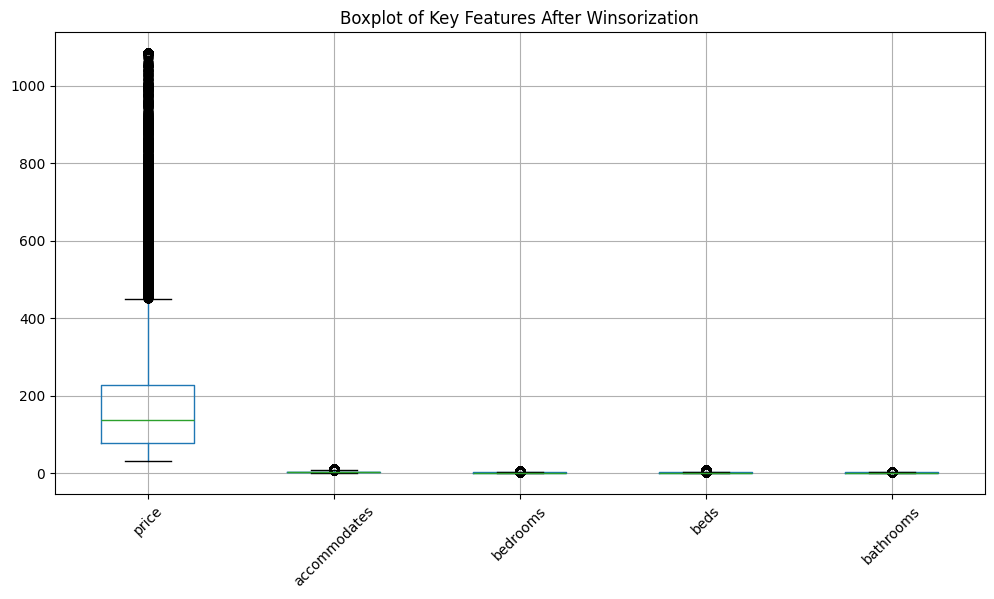

In [18]:
# Define columns to check
outlier_cols = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms']

# Plot boxplots after Winsorization
plt.figure(figsize=(12, 6))
df[outlier_cols].boxplot()
plt.title("Boxplot of Key Features After Winsorization")
plt.xticks(rotation=45)
plt.show()

In [19]:
df['log_price'] = np.log(df['price'])
df[['price', 'log_price']].describe()

,price,log_price
count,61365.000000,61365.000000
mean,188.032413,4.925350
std,176.302619,0.769221
min,30.000000,3.401197
25%,78.000000,4.356709
50%,138.000000,4.927254
75%,227.000000,5.424950
max,1084.000000,6.988413


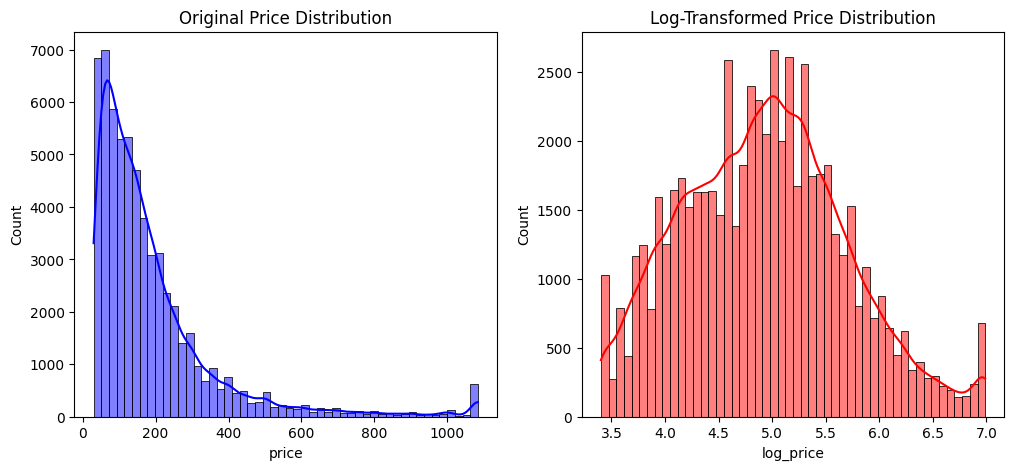

In [20]:
plt.figure(figsize=(12, 5))

# Original price distribution
plt.subplot(1, 2, 1)
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Original Price Distribution")

# Log-transformed price distribution
plt.subplot(1, 2, 2)
sns.histplot(df['log_price'], bins=50, kde=True, color='red')
plt.title("Log-Transformed Price Distribution")

plt.show()

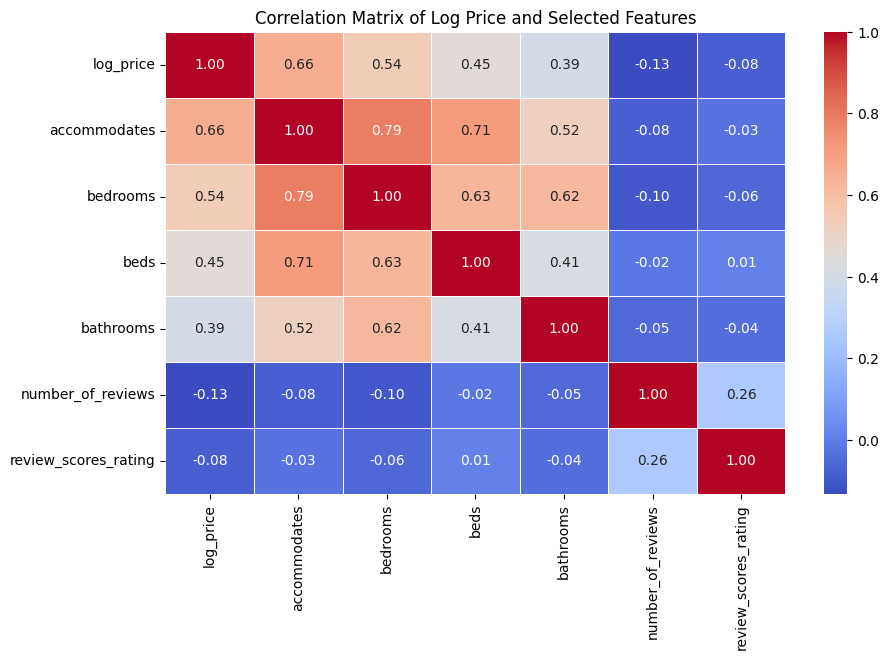

In [21]:
# Compute correlation matrix including log_price
correlation_features = ['log_price', 'accommodates', 'bedrooms', 'beds', 
                        'bathrooms', 'number_of_reviews', 'review_scores_rating']

correlation_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Log Price and Selected Features')
plt.show()

In [22]:
# Update variable
numerical_var = [
    'accommodates', 'bedrooms', 'beds', 'price_log', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count'
]

# Create a copy before normalization
df_original = df.copy()

# Normalize numerical features
scaler = StandardScaler()
df[numerical_var] = scaler.fit_transform(df[numerical_var])

# Display updated dataframe
print(df.head())

KeyError: "['price_log'] not in index"

In [ ]:
# df.to_csv('cleaned_dataset.csv', index=False)

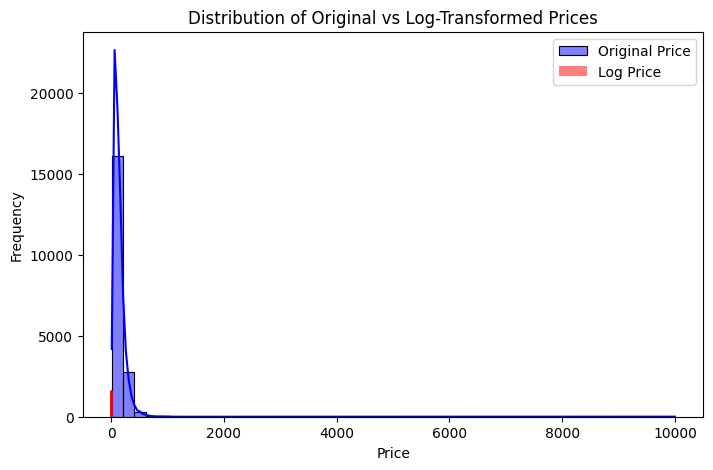

In [ ]:
# Visualization: Log Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_original['price'], bins=50, kde=True, color='blue', label='Original Price')
sns.histplot(df_original['price_log'], bins=50, kde=True, color='red', label='Log Price')
plt.legend()
plt.title('Distribution of Original vs Log-Transformed Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

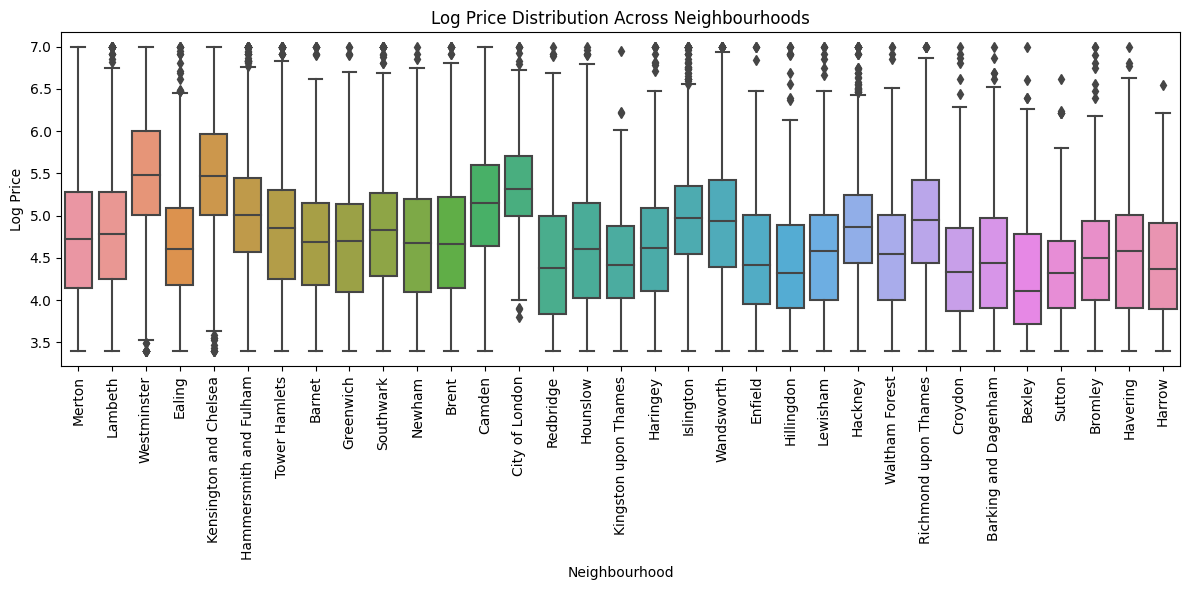

In [ ]:
# Visualization: Price Across Neighborhoods
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='neighbourhood_original', y='log_price')
plt.xticks(rotation=90)
plt.title('Log Price Distribution Across Neighbourhoods')
plt.xlabel('Neighbourhood')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

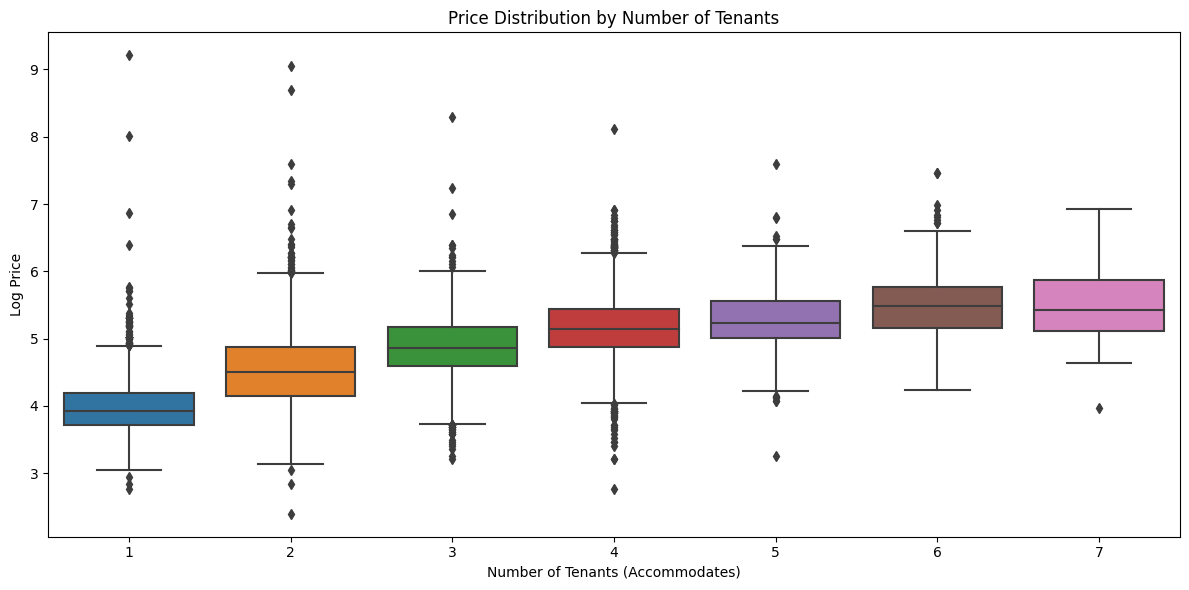

In [ ]:
# Visualization: Price by Number of Tenants (Accommodates)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_original, x='accommodates', y='price_log')
plt.title('Price Distribution by Number of Tenants')
plt.xlabel('Number of Tenants (Accommodates)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

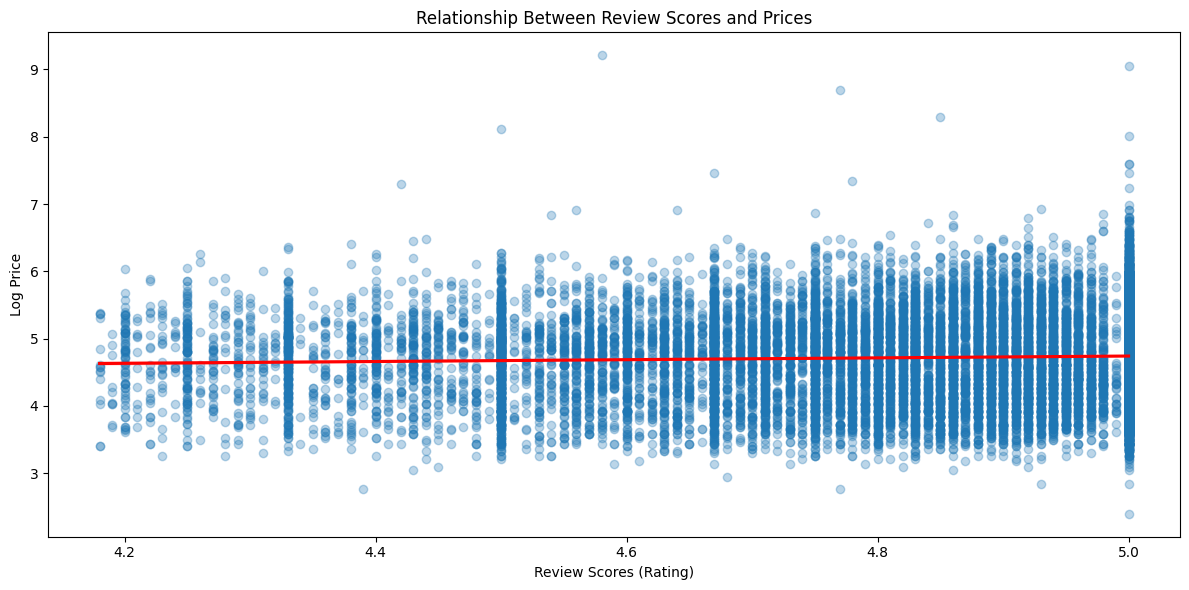

In [ ]:
# Visualization: Relationship Between Review Scores and Prices
plt.figure(figsize=(12, 6))
sns.regplot(
    data=df_original,
    x='review_scores_rating',
    y='price_log',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Review Scores and Prices')
plt.xlabel('Review Scores (Rating)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

## Most important cells

- `Neigbhourhood, Property Type, Room Type, Accomodates, Bedrooms, Beds, Minimum Nights, Number of Reviews, Review Rating, Host is Superhost, Host listing amounts, Calculated Host Listings Count`

## Useless (Potentially)

- `Id, Name, Host id, Host name, Host since` - No influence at all.
- `Amenities` - contains lists of items in the airbnb, won't affect price.
- `First Review, Last Review` - won't affect price

#

## Categorical Variables

Possible Approach
1) One Hot Encode

Converts categorical variables into a binary format.

## Numerical Variables
    'accommodates', 'bedrooms', 'beds', 'price_log', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count'




In [ ]:
correlation_features = [
    'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 
    'review_scores_rating', 'calculated_host_listings_count', 'price_log'
]

# Compute correlation matrix
correlation_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.show()

### Strong Correlations

- `accommodates` (0.65 correlation with price_log) → More guests increase price significantly.
- `bedrooms` (0.48 correlation with price_log) → More bedrooms increase price.
- `beds` (0.35 correlation with price_log) → More beds slightly increase price.

### Weak Correlations

- `number_of_reviews` (-0.08 correlation with price_log) → Almost no effect on price.
- `review_scores_rating` (0.04 correlation with price_log) → Minimal effect on price.
- `calculated_host_listings_count` (0.06 correlation with price_log) → Negligible effect.

In [26]:
from sklearn.model_selection import train_test_split

# ✅ Define features (X) based on strong correlations
selected_features = ['accommodates', 'bedrooms', 'beds', 'log_price']  # Using 'log_price' instead of 'price_log'

# ✅ Ensure all selected features exist in df
X = df[selected_features]
Y = df['price']  # Target variable

# ✅ Split dataset into 80% training and 20% testing
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)

# ✅ Print shapes to verify
print("Training Set Shape:", trainX.shape, trainY.shape)
print("Testing Set Shape:", testX.shape, testY.shape)


Training Set Shape: (49092, 4) (49092,)
Testing Set Shape: (12273, 4) (12273,)


In [27]:
from sklearn.linear_model import LinearRegression

# ✅ Initialize Linear Regression model
model = LinearRegression()

# ✅ Train the model using training data
model.fit(trainX, trainY)

# ✅ Make predictions on the test set
predicted_prices = model.predict(testX)

# ✅ Print first 10 predictions for verification
print("First 10 Predicted Prices:", predicted_prices[:10])

# ✅ Print model coefficients to see how each feature affects price
import pandas as pd
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
print("\nFeature Importance (Linear Regression Coefficients):")
print(coefficients.sort_values(by='Coefficient', ascending=False))


First 10 Predicted Prices: [151.5196723  231.16939146 139.3082633  462.11912345 157.1437903
 229.77957597 139.78690447 223.09124148 119.82067487 -82.05485966]

Feature Importance (Linear Regression Coefficients):
              Coefficient
log_price      200.564395
bedrooms        23.666763
beds             3.201543
accommodates   -10.443329


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Evaluate model performance
r2 = r2_score(testY, predicted_prices)
mse = mean_squared_error(testY, predicted_prices)
mae = mean_absolute_error(testY, predicted_prices)

#-------------------- The labs did not use MSE and MAE
# ✅ Print evaluation results
print("\nModel Performance:")
print(f"R² Score: {r2:.4f}")   # Higher is better (closer to 1)
print(f"MSE: {mse:.4f}")       # Lower is better
print(f"MAE: {mae:.4f}")       # Lower is better



Model Performance:
R² Score: 0.7724
MSE: 7127.8199
MAE: 56.3462


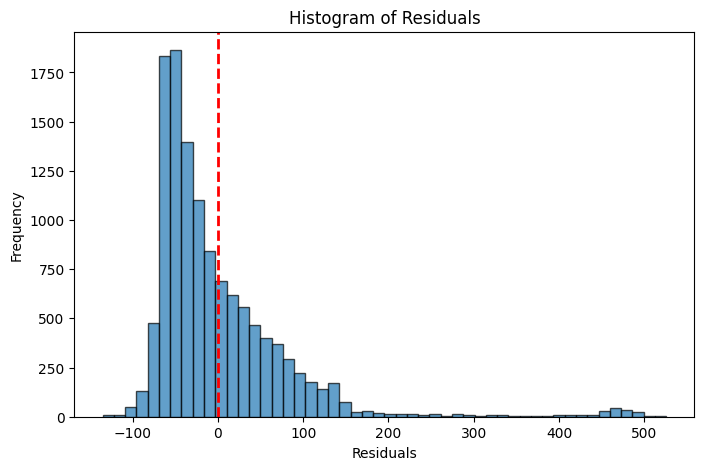

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Compute Residuals
residuals = testY - predicted_prices

# ✅ Plot Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.axvline(x=0, color='red', linestyle='dashed', linewidth=2)
plt.show()


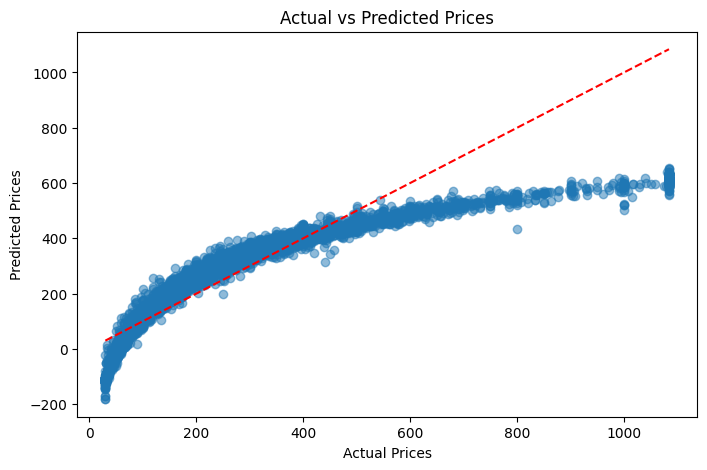

In [30]:
plt.figure(figsize=(8, 5))
plt.scatter(testY, predicted_prices, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.plot([min(testY), max(testY)], [min(testY), max(testY)], color='red', linestyle='dashed')  # Ideal fit line
plt.show()
